# Perceptual Decision Making (Wong & Wang)


- In this exercise we study decision making in a network of competing populations of spiking neurons. The network has been proposed by Wong and Wang in 2006 [1] as a model of decision making in a visual motion detection task. The decision making task and the network are described in the [Neuronal Dynamics by Gerstner - Chapter 16](http://neuronaldynamics.epfl.ch/online/Ch16.html) and in the original publication (see location-references [1]). Read the introduction of chapter [16, Competing populations and decision making](http://neuronaldynamics.epfl.ch/online/Ch16.html). To understand the mechanism of decision making in a network, read [16.2, Competition through common inhibition](http://neuronaldynamics.epfl.ch/online/Ch16.S2.html).


- The exercise is adapted from [here](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/perceptual-decision-making.html).

<img src=https://neuronaldynamics-exercises.readthedocs.io/en/latest/_images/DecisionMaking_PhasePlane_3.png width=800>
<i><center>Decision Space. Each point represents the firing rates of the two subpopulations “Left” and “Right” at a given point in time (averaged over a short time window). The color encodes time. In this example, the decision “Right” is made after about 900 milliseconds.</center></i>

To get a better understanding of the network dynamics, we recommend to solve the exercise spatial-working-memory.

The parameters of our implementation differ from the original paper. In particular, the default network simulates only 480 spiking neurons which leads to relatively short simulation time even on less powerful computers.

**References**

[1] Wong, K.-F. & Wang, X.-J. A Recurrent Network Mechanism of Time Integration in Perceptual Decisions. J. Neurosci. 26, 1314–1328 (2006).

[2] Parts of this exercise and parts of the implementation are inspired by material from *Stanford University, BIOE 332: Large-Scale Neural Modeling, Kwabena Boahen & Tatiana Engel, 2013*, online available.


In [60]:
import brian2 as b2
from neurodynex.tools import plot_tools
from neurodynex.competing_populations import decision_making
import matplotlib.pyplot as plt
import numpy as np

**Accessing a dictionary to plot the population rates.**

The monitors are returned in a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html?highlight=dictionary#dictionaries) providing access to objects by name. Read the [Python documentation](https://docs.python.org/3/tutorial/datastructures.html?highlight=dictionary#dictionaries) and look at the code block below or the function `competing_populations.decision_making.getting_started` to learn how dictionaries are used.

```Python
import brian2 as b2
from neurodynex.tools import plot_tools
from neurodynex.competing_populations import decision_making
import matplotlib.pyplot as plt

results = decision_making.sim_decision_making_network(t_stimulus_start= 50. * b2.ms,
                                                      coherence_level=-0.6,
                                                      max_sim_time=1000. * b2.ms)
plot_tools.plot_network_activity(results["rate_monitor_A"],
                                 results["spike_monitor_A"],
                                 results["voltage_monitor_A"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Left")
plot_tools.plot_network_activity(results["rate_monitor_B"],
                                 results["spike_monitor_B"],
                                 results["voltage_monitor_B"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Right")
plt.show()
```

Remark: The parameter `avg_window_width` is passed to the function [PopulationRateMonitor.smooth\_rate()](http://brian2.readthedocs.io/en/2.0.1/user/recording.html#recording-population-rates) . This function is useful to solve one of the next exercises.

```Python
avg_window_width = 123*b2.ms
sr = results["rate_monitor_A"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
```



simulating 480 neurons. Start: Sat Jul 20 19:46:52 2019
sim end: Sat Jul 20 19:47:46 2019


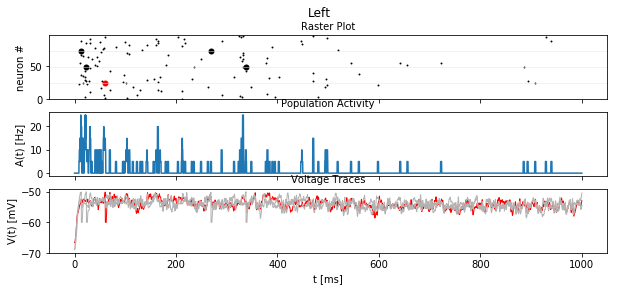

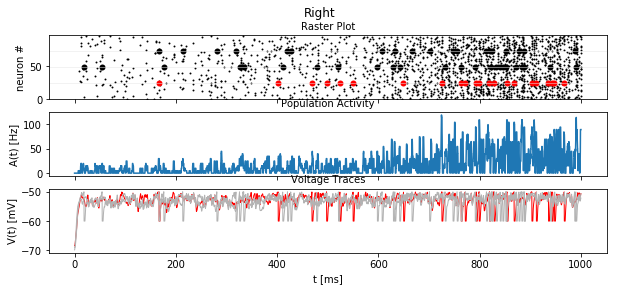

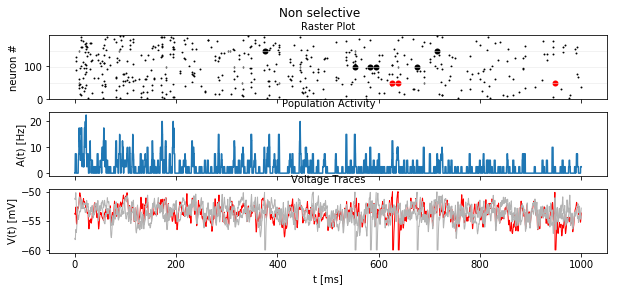

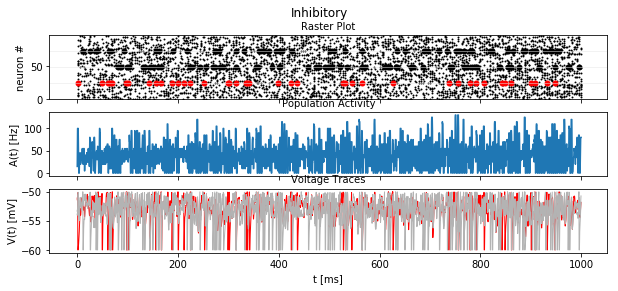

In [5]:
import brian2 as b2
from neurodynex.tools import plot_tools
from neurodynex.competing_populations import decision_making
import matplotlib.pyplot as plt

results = decision_making.sim_decision_making_network(t_stimulus_start= 50. * b2.ms,
                                                      coherence_level=-0.6,
                                                      max_sim_time=1000. * b2.ms)
plot_tools.plot_network_activity(results["rate_monitor_A"],
                                 results["spike_monitor_A"],
                                 results["voltage_monitor_A"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Left")
plot_tools.plot_network_activity(results["rate_monitor_B"],
                                 results["spike_monitor_B"],
                                 results["voltage_monitor_B"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Right")
plot_tools.plot_network_activity(results["rate_monitor_Z"],
                                 results["spike_monitor_Z"],
                                 results["voltage_monitor_Z"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Non selective")
plot_tools.plot_network_activity(results["rate_monitor_inhib"],
                                 results["spike_monitor_inhib"],
                                 results["voltage_monitor_inhib"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Inhibitory")
plt.show()
avg_window_width = 123*b2.ms
sr = results["rate_monitor_A"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz

## Exercise 1 - The Network Implementation

Before we can analyse the decision making process and the simulation results, we first need to understand the structure of the network and how we can access the state variables of the respective subpopulations.

<img src=https://neuronaldynamics-exercises.readthedocs.io/en/latest/_images/DecisionMaking_NetworkStructureAll.png width=600>
<i><center>Network structure. The excitatory population is divided into three subpopulations, shown in the next figure.</center></i>

<img src=https://neuronaldynamics-exercises.readthedocs.io/en/latest/_images/DecisionMaking_NetworkStructureDetail.png width=600>
<i><center>Structure within the excitatory population. The “Left” and “Right” subpopulations have strong recurrent weights ($w^+>w^0$) and weak projections to the other ($w^−<w^0$). All neurons receive a poisson input from an external source. Additionally, the neurons in the “Left” subpopulation receive poisson input with some rate $\nu_\text{Left}$; the “Right” subpopulation receives a poisson input with a different rate $\nu_\text{Right}$.</center></i>


**Understanding Brian2 Monitors.**

The network shown in the figure above is implemented in Brian2 in the function `competing_populations.decision_making.sim_decision_making_network`. Each subpopulation is a [Brian2 NeuronGroup](http://brian2.readthedocs.io/en/stable/user/models.html). Look at the source code of the function `sim_decision_making_network` to answer the following questions:

1.   For each of the four subpopulations, find the variable name of the corresponding [NeuronGroup](http://brian2.readthedocs.io/en/stable/user/models.html). 
2.   Each NeuronGroup is monitored with a [PopulationRateMonitor](http://brian2.readthedocs.io/en/stable/user/recording.html), a [SpikeMonitor](http://brian2.readthedocs.io/en/stable/user/recording.html), and a [StateMonitor](http://brian2.readthedocs.io/en/stable/user/recording.html). Find the variable names for those monitors. Have a look at the [Brian2 documentation](http://brian2.readthedocs.io/en/stable/user/recording.html) if you are not familiar with the concept of monitors.
3.   Which state variable of the neurons is recorded by the [StateMonitor](http://brian2.readthedocs.io/en/stable/user/recording.html)?

1. inhib_pop, excit_pop_A, excit_pop_B, excit_pop_Z
2. rate_monitor_G, spike_monitor_G, voltage_monitor_G where G represents A, B, Z or inhib
3. Voltage

1.   Extend the following code block to include plots for all four subpopulations.
2.   Run the simulation for 800ms. What are the "typical" population rates of the four populations towards the end of the simulation? (In case the network did not decide, run the simulation again).

simulating 480 neurons. Start: Sun Jul 21 13:18:41 2019
sim end: Sun Jul 21 13:19:23 2019


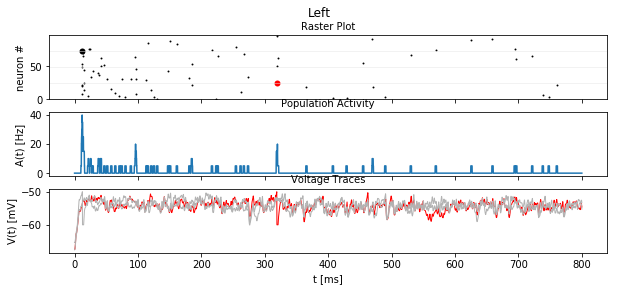

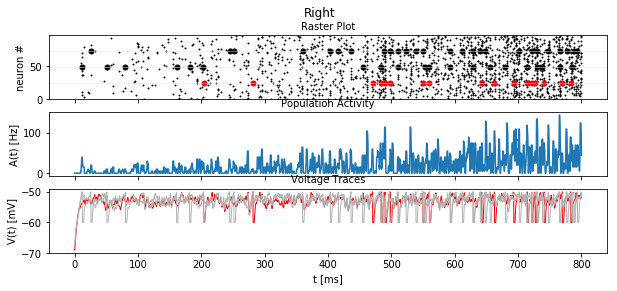

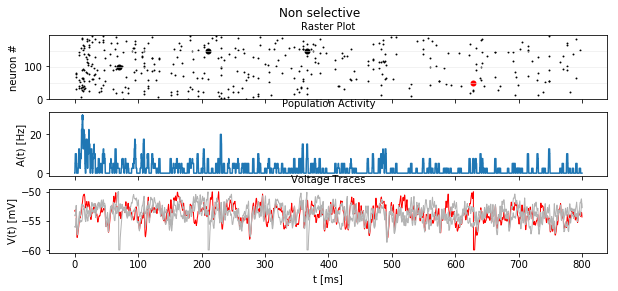

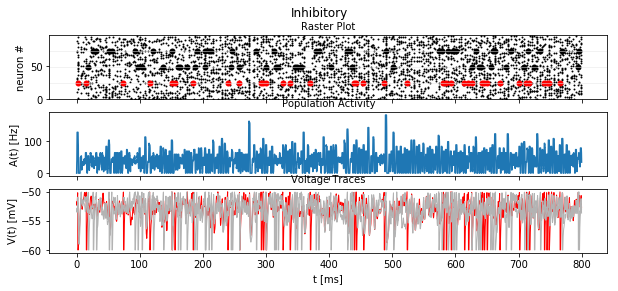

In [8]:
import brian2 as b2
from neurodynex.tools import plot_tools
from neurodynex.competing_populations import decision_making
import matplotlib.pyplot as plt

results = decision_making.sim_decision_making_network(t_stimulus_start= 50. * b2.ms,
                                                      coherence_level=-0.6,
                                                      max_sim_time=800. * b2.ms)
plot_tools.plot_network_activity(results["rate_monitor_A"],
                                 results["spike_monitor_A"],
                                 results["voltage_monitor_A"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Left")
plot_tools.plot_network_activity(results["rate_monitor_B"],
                                 results["spike_monitor_B"],
                                 results["voltage_monitor_B"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Right")
plot_tools.plot_network_activity(results["rate_monitor_Z"],
                                 results["spike_monitor_Z"],
                                 results["voltage_monitor_Z"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Non selective")
plot_tools.plot_network_activity(results["rate_monitor_inhib"],
                                 results["spike_monitor_inhib"],
                                 results["voltage_monitor_inhib"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Inhibitory")
plt.show()

3.   Without running the simulation again, but by using the same `results` [dictionary](https://docs.python.org/3/tutorial/datastructures.html?highlight=dictionary#dictionaries), plot the rates using different values for `avg_window_width`.

INFO       width adjusted from 200. ms to 200.1 ms [brian2.monitors.ratemonitor.adjusted_width]


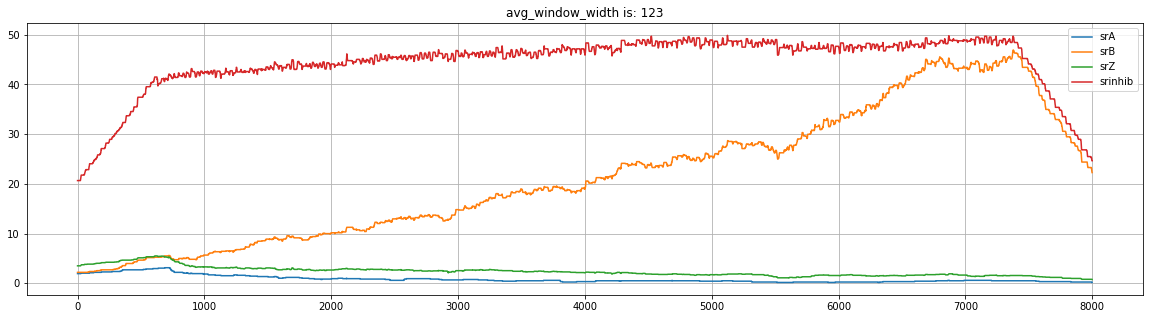

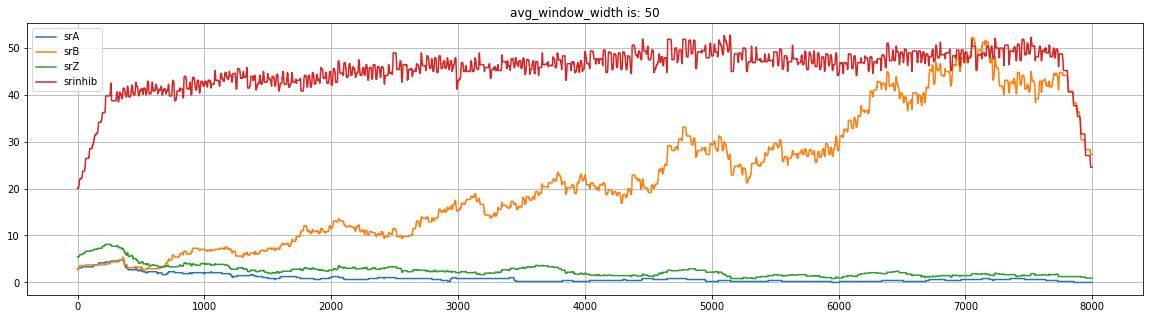

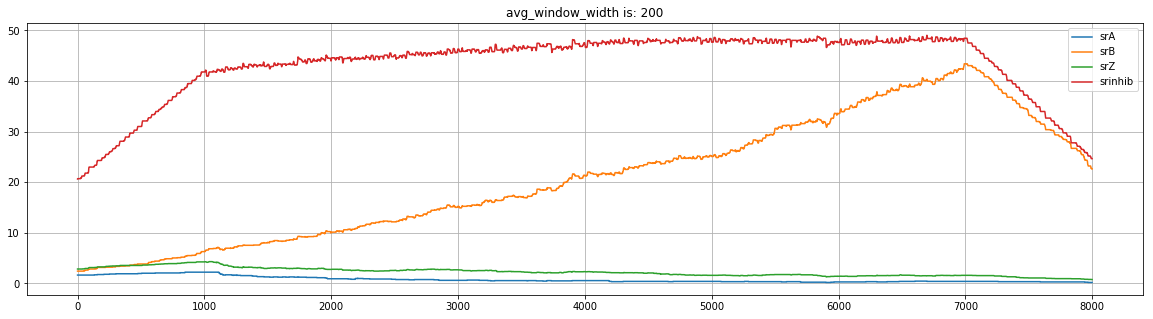

In [10]:
# Second Part of Exercise 1 Rate
import matplotlib.pyplot as plt
avg_window_width = 123*b2.ms
srA = results["rate_monitor_A"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srB = results["rate_monitor_B"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srZ = results["rate_monitor_Z"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srinhib = results["rate_monitor_inhib"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz

ax = plt.figure(figsize=(20,5))
plt.plot(srA, label = "srA")
plt.plot(srB, label = "srB")
plt.plot(srZ, label = "srZ")
plt.plot(srinhib, label = "srinhib")
plt.legend()
plt.title("avg_window_width is: 123")
plt.grid()


avg_window_width = 50*b2.ms
srA = results["rate_monitor_A"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srB = results["rate_monitor_B"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srZ = results["rate_monitor_Z"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srinhib = results["rate_monitor_inhib"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz

plt.figure(figsize=(20,5))
plt.plot(srA, label = "srA")
plt.plot(srB, label = "srB")
plt.plot(srZ, label = "srZ")
plt.plot(srinhib, label = "srinhib")
plt.legend()
plt.title("avg_window_width is: 50")
plt.grid()


avg_window_width = 200*b2.ms
srA = results["rate_monitor_A"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srB = results["rate_monitor_B"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srZ = results["rate_monitor_Z"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srinhib = results["rate_monitor_inhib"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz

plt.figure(figsize=(20,5))
plt.plot(srA, label = "srA")
plt.plot(srB, label = "srB")
plt.plot(srZ, label = "srZ")
plt.plot(srinhib, label = "srinhib")
plt.legend()
plt.title("avg_window_width is: 200")
plt.grid()

4.   Interpret the effect of a very short and a very long averaging window.

5.   Find a value `avg_window_width` for which the population activity plot gives meaningful rates.

123.4

## Exercise 2 - Stimulating the Decision Making Circuit

The input stimulus is implemented by two inhomogenous Poisson processes: The subpopulation "Left" and "Right" receive input from two different PoissonGroups (see Figure "Network Structure"). The input has a "coherence level" $c$ and is noisy. We have implemented this in the following way: every 30ms, the firing rates $\nu_{\text{left}}$ and $\nu_{\text{right}}$ of each of the two PoissonGroups are drawn from a normal distribution:

\begin{align}
\nu_{\text{left}} &\sim& \mathcal{N}(\mu_\text{left},\sigma^{2}) \\
\nu_{\text{right}} &\sim& \mathcal{N}(\mu_\text{right},\sigma^{2}) \\
\mu_{\text{left}} &=& \mu_0  (0.5 + 0.5c) \\
\mu_{\text{right}} &=& \mu_0  (0.5 - 0.5c) \\
c &\in& [-1, +1]
\end{align}

The coherence level $c$, the maximum mean $\mu_0$ and the standard deviation $\sigma$ are parameters of `sim_decision_making_network()`.

**Coherence Level.**

1.   From the equation above, express the difference $\mu_{\text{left}}-\mu_{\text{right}}$  in terms of $\mu_0$ and $c$.
2.   Find the distribution of the difference $\nu_{\text{left}}-\nu_{\text{right}}$. Hint: the difference of two Gaussian distributions is another Gaussian distribution.

Now look at the documentation of the function `sim_decision_making_network()` and find the default values of  $\mu_0$ and $\sigma$. Using those values, answer the following questions:

3.   What are the mean firing rates (in Hz) $\mu_\text{left}$ and $\mu_\text{right}$ for the coherence level $c= -0.2$?
4.   For $c= -0.2$, how does the difference $\mu_{\text{left}}-\mu_{\text{right}}$ compare to the variance of $\nu_{\text{left}}-\nu_{\text{right}}$.

1. $\mu_0*c$
2. $\nu_{left} - \nu_{right} \sim N(mu0 * c, 2sigma^2)$
3. $\mu_{left} = 160*(0.5+0.5*(-0.2)) = 64; mu(right) = 160*(0.5-0.5*(-0.2)) = 96;$
4. $\mu_{left} - \mu_{right} = -34; 2sigma^2 = 2*20^2 = 800$

**Input stimuli with different coherence levels.**

Run a few simulations with `c=-0.1` and `c=+0.6`. Plot the network activity.

simulating 480 neurons. Start: Sun Jul 21 14:00:27 2019
sim end: Sun Jul 21 14:01:14 2019


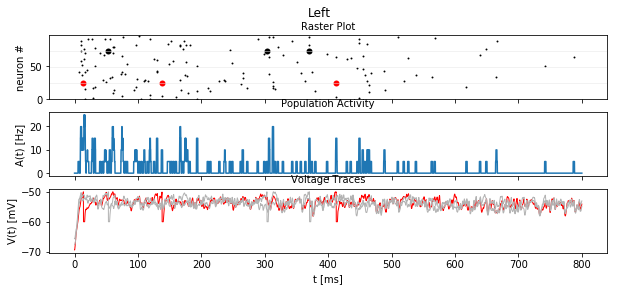

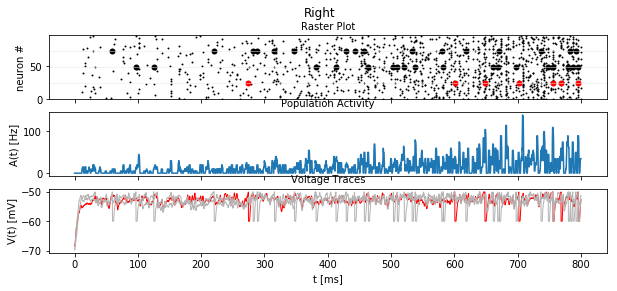

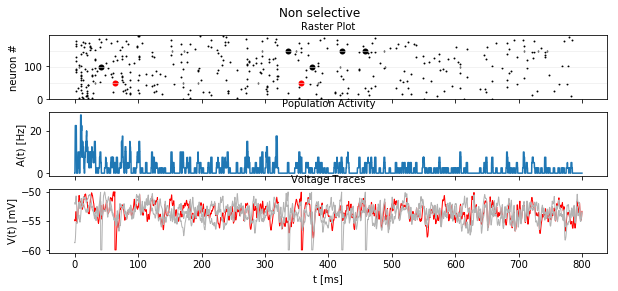

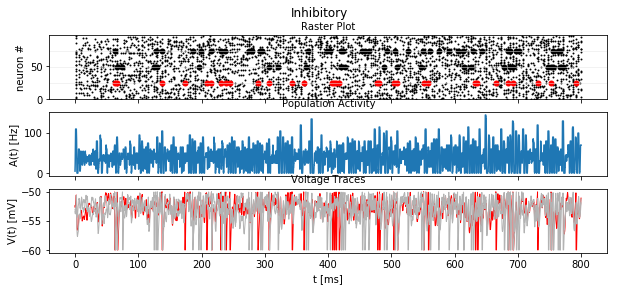

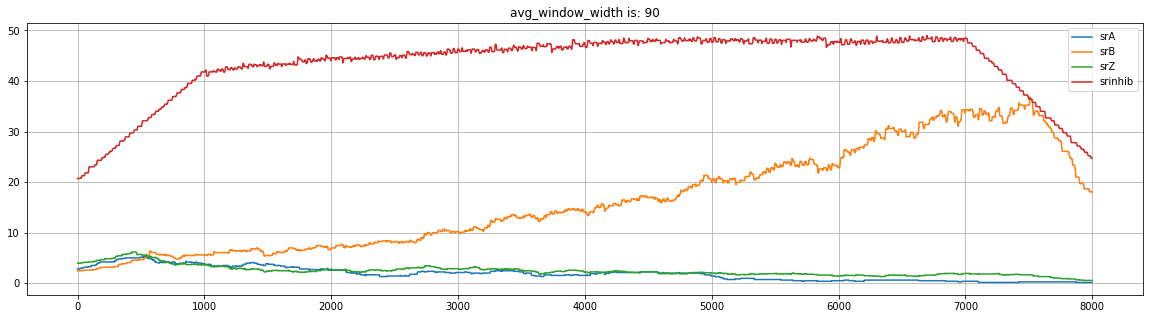

In [16]:
results = decision_making.sim_decision_making_network(t_stimulus_start= 50. * b2.ms,
                                                      coherence_level=-0.1,
                                                      max_sim_time=800. * b2.ms)
plot_tools.plot_network_activity(results["rate_monitor_A"],
                                 results["spike_monitor_A"],
                                 results["voltage_monitor_A"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Left")
plot_tools.plot_network_activity(results["rate_monitor_B"],
                                 results["spike_monitor_B"],
                                 results["voltage_monitor_B"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Right")
plot_tools.plot_network_activity(results["rate_monitor_Z"],
                                 results["spike_monitor_Z"],
                                 results["voltage_monitor_Z"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Non selective")
plot_tools.plot_network_activity(results["rate_monitor_inhib"],
                                 results["spike_monitor_inhib"],
                                 results["voltage_monitor_inhib"],
                                 t_min=0. * b2.ms,
                                 avg_window_width=2. * b2.ms,
                                 sup_title="Inhibitory")
plt.show()
avg_window_width = 90*b2.ms
srA = results["rate_monitor_A"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srB = results["rate_monitor_B"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srZ = results["rate_monitor_Z"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srInhib = results["rate_monitor_inhib"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz

plt.figure(figsize=(20,5))
plt.plot(srA, label = "srA")
plt.plot(srB, label = "srB")
plt.plot(srZ, label = "srZ")
plt.plot(srinhib, label = "srinhib")
plt.legend()
plt.title("avg_window_width is: 90")
plt.grid()

5.  Does the network always make the correct decision?
6.   Look at the population rates and estimate how long it takes the network to make a decision.

5. for c = -0.1: 1/2 simulations - correct decision. Other 1/2 - no decision
6. for c = -0.1: ~500-600 ms

simulating 480 neurons. Start: Sun Jul 21 14:04:14 2019
sim end: Sun Jul 21 14:04:58 2019


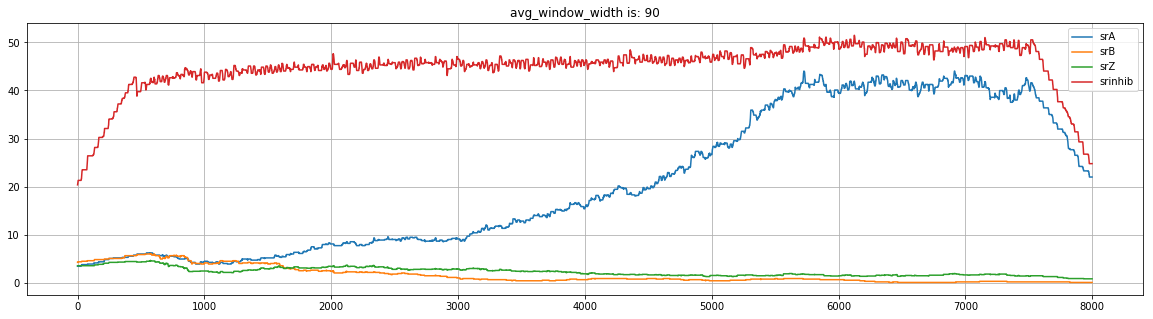

In [20]:
results = decision_making.sim_decision_making_network(t_stimulus_start= 50. * b2.ms,
                                                      coherence_level=+0.9,
                                                      max_sim_time=800. * b2.ms)
avg_window_width = 90*b2.ms
srA = results["rate_monitor_A"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srB = results["rate_monitor_B"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srZ = results["rate_monitor_Z"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz
srinhib = results["rate_monitor_inhib"].smooth_rate(window="flat", width=avg_window_width)/b2.Hz

plt.figure(figsize=(20,5))
plt.plot(srA, label = "srA")
plt.plot(srB, label = "srB")
plt.plot(srZ, label = "srZ")
plt.plot(srinhib, label = "srinhib")
plt.legend()
plt.title("avg_window_width is: 90")
plt.grid()
plt.show()

5. for c = +0.6: every simulation gave correct decision.
6. for c = +0.6: quite different, 300-600 ms


## Exercise 3 - Decision Space

We can visualize the dynamics of the decision making process by plotting the activities of the two subpopulations "Left" / "Right" in a phase plane (see figure at the top of this page). Such a phase plane of competing states is also known as the *Decision Space*. A discussion of the decision making process in the decision space is out of the scope of this exercise but we refer to location-references [1].

**Plotting the Decision Space.**

1.   Write a function that takes two [RateMonitors](http://brian2.readthedocs.io/en/2.0.1/user/recording.html#recording-population-rates) and plots the *Decision Space*.
2.   Add a parameter `avg_window_width` to your function (same semantics as in the exercise above). Run a few simulations and plot the phase plane for different values of `avg_window_width`.
3.   We can use a rate threshold as a decision criterion: We say the network has made a decision if one of the (smoothed) rates crosses a threshold. What are appropriate values for `avg_window_width` and `rate_threshold` to detect a decision from the two rates?

Hint: Use Brian's `smooth_rate()` function:

```Python
avg_window_width = 100*b2.ms
sr = results["rate_monitor_A"].smooth_rate(window="flat",
                                           width=avg_window_width)/b2.Hz
```

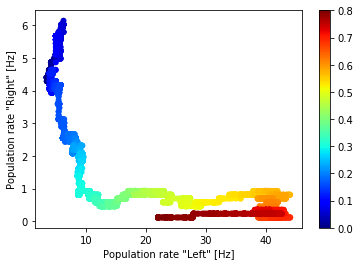

In [25]:
#set the time title
#create time to run function or find brian time vector
def plotDecisionSpace(srA,srB,t,avg_window_width):
    a = plt.scatter(srA, srB, c=t, cmap='jet',lw = 0)
    plt.xlabel('Population rate "Left" [Hz]')
    plt.ylabel('Population rate "Right" [Hz]')
    b = plt.colorbar(a)
    b.ax.set_label("Time [seconds]")
    plt.show()  
       
avg_window_width = 90*b2.ms
srA = results["rate_monitor_A"].smooth_rate(window="flat",width=avg_window_width)/b2.Hz
srB = results["rate_monitor_B"].smooth_rate(window="flat",width=avg_window_width)/b2.Hz
t = np.linspace(0,800e-3,len(srA))

plotDecisionSpace(srA,srB,t,avg_window_width)

3. avg_window_rate = 90
   rate_threshold = 20 Hz (45?)
  
In the documentation of "multiple_simulations" rate threshold is 25 and avg_window_width is 30.

**Implementing a decision criterion.**

4.   Using your insights from the previous questions, implement a function `get_decision_time()` that takes two [RateMonitors](http://brian2.readthedocs.io/en/2.0.1/user/recording.html#recording-population-rates), an `avg_window_width` and a `rate_threshold`. The function should return a tuple `(decision_time_left, decision_time_right)`. The decision time is the time index when some decision boundary is crossed. Possible return values are (1234.5ms, 0ms) for decision "Left", (0ms, 987.6ms) for decision "Right" and (0ms, 0ms) for the case when no decision is made within the simulation time. A return value like (123ms, 456ms) is an error and occurs if your function is called with inappropriate values for `avg_window_width` and `rate_threshold`.

> The following code block shows how your function is called.

```Python
>> get_decision_time(results["rate_monitor_A"],
                     results["rate_monitor_B"],
                     avg_window_width=123*b2.ms,
                     rate_threshold=45.6*b2.Hz)
>> (0.543 * second, 0. * second)
```

The following code fragments could be useful:

```Python
smoothed_rates_A = rate_monitor_A.smooth_rate(window="flat",
                                              width=avg_window_width) / b2.Hz
idx_A = numpy.argmax(smoothed_rates_A > rate_threshold/b2.Hz)
t_A = idx_A * b2.defaultclock.dt
```

Run a few simulations to test your function.

In [73]:
def get_decision_time(rate_monitor_A, rate_monitor_B, avg_window_width, rate_threshold):
    smoothed_rates_A = rate_monitor_A.smooth_rate(window="flat",width=avg_window_width) / b2.Hz
    idx_A = np.argmax(smoothed_rates_A > rate_threshold/b2.Hz)
    t_A = idx_A * b2.defaultclock.dt

    smoothed_rates_B = rate_monitor_B.smooth_rate(window="flat",width=avg_window_width) / b2.Hz
    idx_B = np.argmax(smoothed_rates_B > rate_threshold/b2.Hz)
    t_B = idx_B * b2.defaultclock.dt
    
    return t_A,t_B

thresh = (20)*b2.Hz
avg_window_width=90*b2.ms
temp = get_decision_time(results["rate_monitor_A"],results["rate_monitor_B"],avg_window_width, thresh)
print(temp)



(0.4262 * second, 0. * second)


## Exercise 4 - Percent-correct and Decision-time as a Function of Coherence Level

We now investigate how the coherence level influences the decision making process. In order to estimate quantities like "Percent-correct" or "Decision-time", we have to average over multiple repetitions.

**Running multiple simulations.**

Use the function `competing_populations.decision_making.run_multiple_simulations()` to get the values for multiple runs. Pass your function `get_decision_time()` to `run_multiple_simulations()` as shown here:

``` Python
coherence_levels = [-0.1, -0.5]  # for negative values, B is the correct decision.
nr_repetitions = 3

time_to_A,\
time_to_B,\
count_A,\
count_B,\
count_No = decision_making.run_multiple_simulations(get_decision_time,
                                                    coherence_levels,
                                                    nr_repetitions,
                                                    max_sim_time=??,
                                                    rate_threshold=??,
                                                    avg_window_width=??)
```

1.   See the doc of `run_multiple_simulations()` to understand the parameters and return values.
2.   Write a function that takes `coherence_levels, time_to_A, time_to_B, count_A, count_B, count_No` and writes "Percent correct" (for each level in `coherence_levels`) to the terminal.
3.   Think about other values you could get from the data. Add them to your function.

In [74]:
coherence_levels = [-0.1, -0.5]  # for negative values, B is the correct decision.
nr_repetitions = 3
max_sim_time=800. * b2.ms
rate_threshold = (25)*b2.Hz
avg_window_width = 90*b2.ms
time_to_A, time_to_B, count_A, count_B, count_No = decision_making.run_multiple_simulations(get_decision_time, 
                                                                                coherence_levels,
                                                    nr_repetitions,
                                                    max_sim_time,
                                                    rate_threshold,
                                                    avg_window_width)


********************************************
coherence_level=-0.1
i_run=0
simulating 480 neurons. Start: Sun Jul 21 16:13:06 2019
sim end: Sun Jul 21 16:14:31 2019
t_A=0.0, t_B=0.0
no decision
i_run=1
simulating 480 neurons. Start: Sun Jul 21 16:14:31 2019
sim end: Sun Jul 21 16:16:00 2019
t_A=0.0, t_B=0.0
no decision
i_run=2
simulating 480 neurons. Start: Sun Jul 21 16:16:00 2019
sim end: Sun Jul 21 16:16:46 2019
t_A=0.0, t_B=0.6084
decision: B
********************************************
coherence_level=-0.5
i_run=0
simulating 480 neurons. Start: Sun Jul 21 16:16:46 2019
sim end: Sun Jul 21 16:17:43 2019
t_A=0.0, t_B=0.0
no decision
i_run=1
simulating 480 neurons. Start: Sun Jul 21 16:17:44 2019
sim end: Sun Jul 21 16:18:43 2019
t_A=0.0, t_B=0.0
no decision
i_run=2
simulating 480 neurons. Start: Sun Jul 21 16:18:43 2019
sim end: Sun Jul 21 16:19:40 2019
t_A=0.0, t_B=0.7791
decision: B


In [75]:
print(time_to_A)
print(time_to_B)
print(count_A)
print(count_B)
print(count_No)

[[0. 0. 0.]
 [0. 0. 0.]]
[[0.     0.     0.6084]
 [0.     0.     0.7791]]
[0 0]
[1 1]
[2 2]


[33.33333333333333, 33.33333333333333]


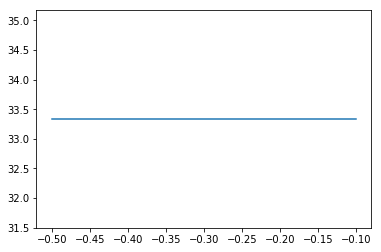

In [76]:
def perc_corr(coherence_levels, count_A, count_B, count_No):
    perccorr = []
    for num, i in enumerate(coherence_levels):
        if i < 0:
            perccorr.append((count_B/(count_A+count_B+count_No))[num]*100)
        else: 
            perccorr.append((count_A/(count_A+count_B+count_No))[num]*100)
    return perccorr

a = perc_corr(coherence_levels, count_A, count_B, count_No)
print(a)
plt.plot(coherence_levels, a)
plt.show()

[[0. 0. 0.]
 [0. 0. 0.]] [[0.     0.     0.6084]
 [0.     0.     0.7791]]


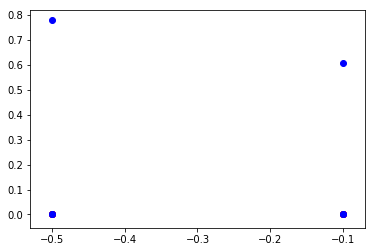

In [77]:
def time_plot(time_to_A, time_to_B, nr_repetitions):    
    cohPlot = np.zeros((2,nr_repetitions))
    for i in range(cohPlot.shape[0]):
        for j in range(cohPlot.shape[1]):
            cohPlot[i][j] = coherence_levels[i]

    plt.scatter(cohPlot, time_to_A, color='red')
    plt.scatter(cohPlot, time_to_B, color='blue')
    plt.show()

print(time_to_A, time_to_B)
ploot = time_plot(time_to_A, time_to_B, nr_repetitions)

**Percent-Correct, Time-to-decision.**

Using `run_multiple_simulations()`, run at least 20 simulations for each of the two `coherence_levels = [+0.15, -0.8]` and visualize the results. Warning: Depending on your computer, this simulation could run for more than an hour.

4.   Visualize "Percent correct" versus "coherence level". Count simulations with "no decision" as wrong.
5.   Visualize "Time to decision" versus "coherence level". Ignore simulations with "no decision".
6.   Discuss your results.
7.   Optionally, if you have sufficient time/computing-power, you could run more levels.

```Python
import brian2 as b2
from neurodynex.competing_populations import decision_making

coherence_levels = [0.15, -0.8]
nr_repetitions = 20

# do not set other parameters (=defaults are used).
time_to_A,\
time_to_B,\
count_A,\
count_B,\
count_No = decision_making.run_multiple_simulations(get_decision_time,
                                                    coherence_levels,
                                                    nr_repetitions,
                                                    max_sim_time=1200 * b2.ms)

# you may want to wrap the visualization into a function
# plot_simulation_stats(coherence_levels, time_to_A, time_to_B, count_A, count_B, count_No)
```

In [78]:
coherence_levels = [0.15, -0.8]
nr_repetitions = 20
rate_threshold = (25)*b2.Hz
avg_window_width = 90*b2.ms
time_to_A, time_to_B, count_A, count_B, count_No = decision_making.run_multiple_simulations(get_decision_time, 
                                                                                coherence_levels,
                                                    nr_repetitions,
                                                    max_sim_time,
                                                    rate_threshold,
                                                    avg_window_width)

********************************************
coherence_level=0.15
i_run=0
simulating 480 neurons. Start: Sun Jul 21 16:20:25 2019


KeyboardInterrupt: 

In [66]:
print("t to A:", time_to_A)
print("t to B:", time_to_B)
print("number A:", count_A)
print("number B:", count_B)
print("number no:", count_No)

t to A: [[0.     0.6469 0.7913 0.     0.     0.     0.     0.7561 0.     0.3234
  0.5495 0.8169 0.     0.     0.     0.4778 0.8196 0.694  0.4987 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.688  0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
t to B: [[0.     0.     0.     0.746  0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.7588]
 [0.3807 0.6369 0.6662 0.4689 0.6301 0.3276 0.6626 0.3399 0.     0.7133
  0.5364 0.6765 0.5233 0.6662 0.4388 0.4692 0.6461 0.5008 0.5368 0.7   ]]
number A: [10  1]
number B: [ 2 19]
number no: [8 0]


[50.0, 95.0]


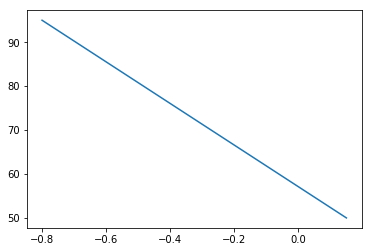

In [71]:
b = perc_corr(coherence_levels, count_A, count_B, count_No)
print(b)
plt.plot(coherence_levels, b)
plt.show()

[[0.     0.6469 0.7913 0.     0.     0.     0.     0.7561 0.     0.3234
  0.5495 0.8169 0.     0.     0.     0.4778 0.8196 0.694  0.4987 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.688  0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]] [[0.     0.     0.     0.746  0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.7588]
 [0.3807 0.6369 0.6662 0.4689 0.6301 0.3276 0.6626 0.3399 0.     0.7133
  0.5364 0.6765 0.5233 0.6662 0.4388 0.4692 0.6461 0.5008 0.5368 0.7   ]]


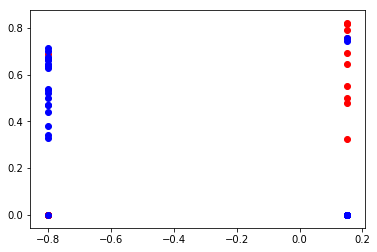

In [72]:
print(time_to_A, time_to_B)
ploot2 = time_plot(time_to_A, time_to_B, nr_repetitions)